## 🧠 Notebook Context – Real vs. Fake Review Classification with BERT (Using Class Weights)
This notebook extends the baseline model by incorporating class weights to better handle the class imbalance present in the dataset.

### 📊 Dataset Overview
- Total Samples: 20,000
- Class Distribution: 90% real (majority class), 10% fake (minority class)
- Source: Synthetically created using ChatGPT
- Imbalance Strategy: This version of the notebook uses class weights to ensure that the minority class (fake reviews) is given proportionally higher importance during training.

**⚖️ What are Class Weights?**

**Class weighting is a technique that adjusts the loss function so that misclassifying minority class samples incurs a higher penalty than misclassifying majority class ones. This helps the model focus more on the underrepresented class without altering the data distribution.**

### 🧠 Model Architecture
- Model: bert-base-cased from Hugging Face Transformers
- Training: Fine-tuned with class-weighted loss to counteract the class imbalance

### 📈 Evaluation Metrics
To comprehensively assess performance, the following metrics are used:

- Confusion Matrix
- Accuracy (not a reliable metric due to imbalance)
- Precision
- Recall
- F1 Score
- ROC Curve
- PR Curve (preferred in imbalanced scenarios)

⚠️ Note: In imbalanced datasets, metrics like PR Curve and F1 Score are far more indicative of true model performance than accuracy or even the ROC curve. Class weights improve the model's ability to correctly identify fake reviews by emphasizing their importance in the learning process.

## Import Libraries

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system =

In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.5 MB/s eta 0:00:00


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset, Dataset, DatasetDict
from sklearn.utils.class_weight import compute_class_weight
import torch
import numpy as np
from torch import nn
from transformers import DataCollatorWithPadding
from sklearn.metrics import f1_score
import numpy as np
from collections import Counter
import pandas as pd
from google.colab import files
import io

## Import Dataset, Then split and convert to DataDict

In [ ]:
# Step 1: Upload a file from your local machine
uploaded = files.upload()

# Step 2: Read the uploaded file into a pandas DataFrame
# Assuming the uploaded file is a CSV
for filename in uploaded.keys():
    print(f"Reading file: {filename}")
    df = pd.read_csv(io.BytesIO(uploaded[filename]))
    break  # Only read the first file uploaded

# Step 3: Display the first few rows of the DataFrame
df.head()

Saving Combined_Real_vs_Fake_Reviews_Dataset__20_000_Samples_.csv to Combined_Real_vs_Fake_Reviews_Dataset__20_000_Samples_ (1).csv
Reading file: Combined_Real_vs_Fake_Reviews_Dataset__20_000_Samples_ (1).csv


,text,label
0,I can't stop recommending this to everyone I k...,0
1,I can't stop recommending this to everyone I k...,0
2,Absolutely amazing! I would buy this again and...,0
3,Exceeded my expectations. Perfect in every way...,0
4,"Unbelievable performance, can't live without i...",0


In [ ]:
df['label'].value_counts()

,count
label,
0,18000
1,2000


In [ ]:
df.rename(columns={'label': 'labels'}, inplace=True)
df.head()

,text,labels
0,I can't stop recommending this to everyone I k...,0
1,I can't stop recommending this to everyone I k...,0
2,Absolutely amazing! I would buy this again and...,0
3,Exceeded my expectations. Perfect in every way...,0
4,"Unbelievable performance, can't live without i...",0


In [ ]:
import numpy as np
train, validate, test = np.split(df.sample(frac=1, random_state=42),[int(.6*len(df)),int(.8*len(df))])

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [ ]:
train = train.reset_index()[['text','labels']]
validate = validate.reset_index()[['text','labels']]
test = test.reset_index()[['text','labels']]

In [ ]:
tds = Dataset.from_pandas(train)
vds = Dataset.from_pandas(validate)
teds = Dataset.from_pandas(test)

In [ ]:
dataset = DatasetDict()
dataset["train"] = tds
dataset["validate"] = vds
dataset["test"] = teds

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 12000
    })
    validate: Dataset({
        features: ['text', 'labels'],
        num_rows: 4000
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 4000
    })
})

In [ ]:
# Check the number of records after over sampling
label_counts = Counter(dataset["train"]["labels"])
print(sorted(label_counts.items()))

[(0, 10806), (1, 1194)]


## Tokenizer

In [ ]:
# ✅ Tokenization
model_ckpt ="bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize(example):
    return tokenizer(example["text"], truncation=True)

tokenized = dataset.map(tokenize, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

In [ ]:
tokenized

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 12000
    })
    validate: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4000
    })
    test: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4000
    })
})

In [ ]:
tokenized['train'][0]

{'text': 'Not as described but customer service helped. Purchased from Thompson, Smith and Duncan on 2025-01-06.',
 'labels': 0,
 'input_ids': [101,
  2025,
  2004,
  2649,
  2021,
  8013,
  2326,
  3271,
  1012,
  4156,
  2013,
  5953,
  1010,
  3044,
  1998,
  7343,
  2006,
  16798,
  2629,
  1011,
  5890,
  1011,
  5757,
  1012,
  102],
 'token_type_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1]}

## Class weight method

In [ ]:
# ✅ Compute class weights
y_train = tokenized['train']['labels']
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

In [ ]:
class_weights

array([0.55524708, 5.02512563])

In [ ]:
class_weights = torch.tensor(class_weights, dtype=torch.float)
num_labels = len(set(dataset['train']['labels']))

In [ ]:
class_weights

tensor([0.5552, 5.0251])

In [ ]:
num_labels

2

In [ ]:
# ✅ Define custom model with weighted loss
class WeightedModel(nn.Module):
    def __init__(self, model_name, num_labels, class_weights):
        super().__init__()
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
        self.loss_fn = nn.CrossEntropyLoss(weight=class_weights)
    def forward(self, input_ids=None, attention_mask=None, labels=None):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=None)
        logits = outputs.logits
        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)
        return {'loss': loss, 'logits': logits}

model = WeightedModel(model_ckpt, num_labels=num_labels, class_weights=class_weights)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Compute Metrics

In [ ]:
import evaluate
import numpy as np

# Load required metrics
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

# Define compute_metrics using evaluate
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Compute individual metrics
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    macro_precision = precision_metric.compute(predictions=predictions, references=labels, average="macro")
    macro_recall = recall_metric.compute(predictions=predictions, references=labels, average="macro")
    macro_f1 = f1_metric.compute(predictions=predictions, references=labels, average="macro")

    weighted_precision = precision_metric.compute(predictions=predictions, references=labels, average="weighted")
    weighted_recall = recall_metric.compute(predictions=predictions, references=labels, average="weighted")
    weighted_f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")

    # Combine all into one dictionary
    return {
        "accuracy": accuracy["accuracy"],
        "macro_precision": macro_precision["precision"],
        "macro_recall": macro_recall["recall"],
        "macro_f1": macro_f1["f1"],
        "weighted_precision": weighted_precision["precision"],
        "weighted_recall": weighted_recall["recall"],
        "weighted_f1": weighted_f1["f1"]
    }

## Training Arguments

In [ ]:
# ✅ TrainingArguments
args = TrainingArguments(
    output_dir="results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    report_to="none",
)

## Train Model

In [ ]:
# ✅ Trainer setup and training
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validate"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

<ipython-input-93-9909d877a0ed>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1,Weighted Precision,Weighted Recall,Weighted F1
1,0.575900,0.586313,0.520500,0.558855,0.665736,0.451134,0.887321,0.520500,0.608207
2,0.555100,0.550727,0.845000,0.619898,0.669408,0.636961,0.875479,0.845000,0.858191
3,0.547700,0.573646,0.846750,0.622728,0.672665,0.640102,0.876546,0.846750,0.859636


TrainOutput(global_step=2250, training_loss=0.5595829671223959, metrics={'train_runtime': 312.098, 'train_samples_per_second': 115.348, 'train_steps_per_second': 7.209, 'total_flos': 0.0, 'train_loss': 0.5595829671223959, 'epoch': 3.0})

## Evaluate Model

In [ ]:
trainer.evaluate()

{'eval_loss': 0.5736456513404846,
 'eval_accuracy': 0.84675,
 'eval_macro_precision': 0.6227282067126794,
 'eval_macro_recall': 0.672664962000142,
 'eval_macro_f1': 0.6401018693713627,
 'eval_weighted_precision': 0.8765460020628457,
 'eval_weighted_recall': 0.84675,
 'eval_weighted_f1': 0.859635680200862,
 'eval_runtime': 6.8632,
 'eval_samples_per_second': 582.822,
 'eval_steps_per_second': 36.426,
 'epoch': 3.0}

In [ ]:
trainer.state.best_model_checkpoint

'results/checkpoint-1500'

In [ ]:
dataset["test"]

Dataset({
    features: ['text', 'labels'],
    num_rows: 4000
})

In [ ]:
tokenized['test']

Dataset({
    features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 4000
})

In [ ]:
test_metrics = trainer.evaluate(eval_dataset= tokenized['test'])
print(test_metrics)

{'eval_loss': 0.5607530474662781, 'eval_accuracy': 0.84125, 'eval_macro_precision': 0.6308444444444444, 'eval_macro_recall': 0.6851176167582418, 'eval_macro_f1': 0.6493804317562493, 'eval_weighted_precision': 0.8732316444444443, 'eval_weighted_recall': 0.84125, 'eval_weighted_f1': 0.8548021256380345, 'eval_runtime': 7.285, 'eval_samples_per_second': 549.07, 'eval_steps_per_second': 34.317, 'epoch': 3.0}


In [ ]:
trainer.predict(tokenized['test'])

PredictionOutput(predictions=array([[-0.07848952, -0.6418935 ],
       [ 1.0983382 , -1.5825039 ],
       [-0.4190297 , -0.4800878 ],
       ...,
       [-0.37915277, -0.6600261 ],
       [-0.2659427 , -0.47637638],
       [-0.827392  ,  0.7902205 ]], dtype=float32), label_ids=array([0, 0, 0, ..., 0, 0, 0]), metrics={'test_loss': 0.5607530474662781, 'test_accuracy': 0.84125, 'test_macro_precision': 0.6308444444444444, 'test_macro_recall': 0.6851176167582418, 'test_macro_f1': 0.6493804317562493, 'test_weighted_precision': 0.8732316444444443, 'test_weighted_recall': 0.84125, 'test_weighted_f1': 0.8548021256380345, 'test_runtime': 7.3661, 'test_samples_per_second': 543.028, 'test_steps_per_second': 33.939})

## ROC Curve

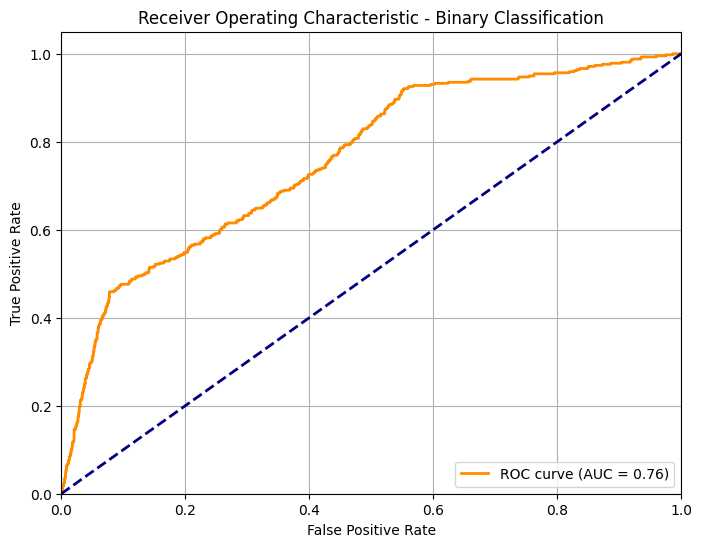

-----------------------------------------------------------------------------------------
X-Axis: False Positive Rate (FPR) = FP / FP+TN
Y-Axis: True Positive Rate (TPR) (also called Recall or Sensitivity) = TP / TP+FN


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

predictions = trainer.predict(tokenized["test"])

logits = predictions.predictions
label_ids = predictions.label_ids

# Step 1: Apply softmax to convert logits to probabilities
from scipy.special import softmax
probs = softmax(logits, axis=1)
positive_class_probs = probs[:, 1]  # probability of class 1

# Step 2: Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(predictions.label_ids, positive_class_probs)
roc_auc = auc(fpr, tpr)

# Step 3: Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Binary Classification')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print("-----------------------------------------------------------------------------------------")
print("X-Axis: False Positive Rate (FPR) = FP / FP+TN")
print("Y-Axis: True Positive Rate (TPR) (also called Recall or Sensitivity) = TP / TP+FN")

## Precision-Recall Curve

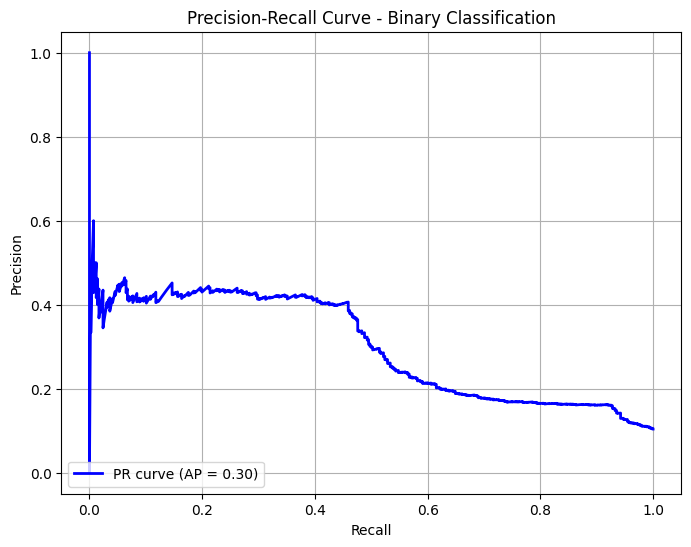

-----------------------------------------------------------------------------------------
X-Axis: True Positive Rate (TPR) (also called Recall or Sensitivity) = TP / TP+FN
Y-Axis: Precision = TP / TP+FP

Precision and Recall at different thresholds:
Threshold: 0.1 | Precision: 0.16, Recall: 0.93
Threshold: 0.2 | Precision: 0.16, Recall: 0.93
Threshold: 0.3 | Precision: 0.16, Recall: 0.93
Threshold: 0.4 | Precision: 0.16, Recall: 0.88
Threshold: 0.5 | Precision: 0.32, Recall: 0.49
Threshold: 0.6 | Precision: 0.40, Recall: 0.45
Threshold: 0.7 | Precision: 0.40, Recall: 0.45
Threshold: 0.8 | Precision: 0.40, Recall: 0.45
Threshold: 0.9 | Precision: 0.10, Recall: 1.00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Step 1: Apply softmax to convert logits to probabilities
from scipy.special import softmax
probs = softmax(logits, axis=1)
positive_class_probs = probs[:, 1]  # Probability of class 1 (positive class)

# Step 2: Compute Precision-Recall curve and Average Precision (AP)
precision, recall, thresholds = precision_recall_curve(label_ids, positive_class_probs)
average_precision = average_precision_score(label_ids, positive_class_probs)

# Step 3: Plot the Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', lw=2, label=f'PR curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Binary Classification')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

print("-----------------------------------------------------------------------------------------")
print("X-Axis: True Positive Rate (TPR) (also called Recall or Sensitivity) = TP / TP+FN")
print("Y-Axis: Precision = TP / TP+FP")

print("\nPrecision and Recall at different thresholds:")
for t in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    idx = np.argmax(thresholds >= t)
    if idx < len(precision):
        print(f"Threshold: {t:.1f} | Precision: {precision[idx]:.2f}, Recall: {recall[idx]:.2f}")

## F1 vs Threshold Curve

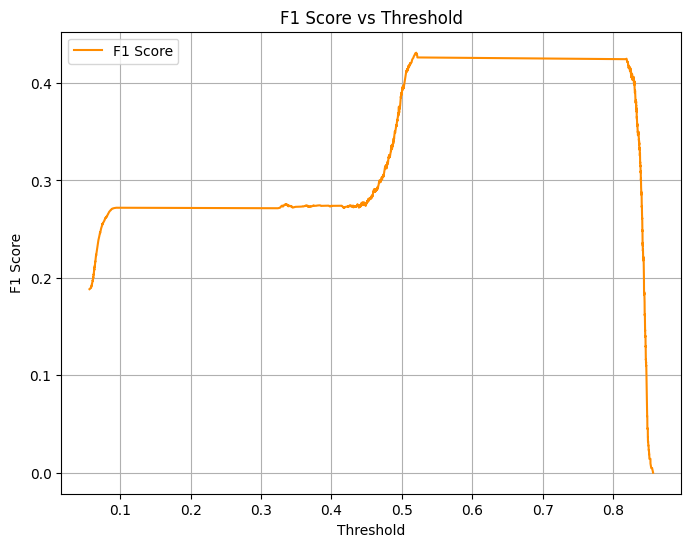


Best F1 = 0.43 at threshold ≈ 0.52


In [ ]:
# Step 5: Plot F1 score vs threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_scores[:-1], label="F1 Score", color='darkorange')
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Threshold")
plt.grid(True)
plt.legend()
plt.show()

# Step 6: Best F1 and corresponding threshold
best_idx = np.argmax(f1_scores[:-1])  # exclude final point which has no threshold
print(f"\nBest F1 = {f1_scores[best_idx]:.2f} at threshold ≈ {thresholds[best_idx]:.2f}")

## Confusion matrix

In [ ]:
from collections import Counter

# Convert each label tensor to a plain integer
labels = [int(label) for label in tokenized['test']["labels"]]

# Now count them
label_counts = Counter(labels)

# Print the results nicely
print(label_counts)

Counter({0: 3584, 1: 416})


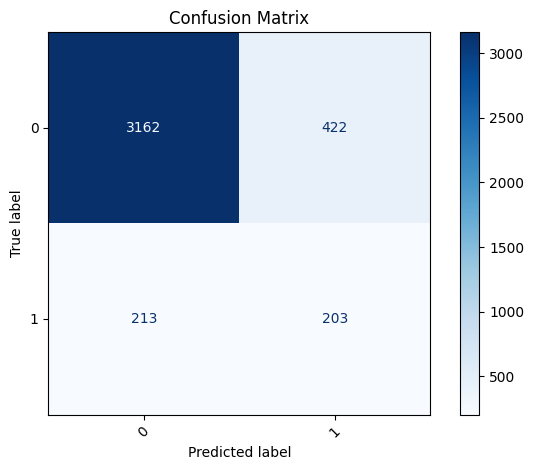


=== Evaluation Metrics ===
Accuracy:- Out of all the predictions we made, How many were True.
TP+TN / TP+TN+FP+FN
Accuracy:  0.8413
-----------------------------------------------
Precision:- Out of all the positive predictions we made, How many were True?
TP / TP+FP
Precision: 0.3248
-----------------------------------------------
Recall:- Out of all the data points that should be predicted as True, How many we correctly predict as True?
TP / TP+FN
Recall:    0.4880
-----------------------------------------------
F1 Score:- Harmonic mean of Precision and Recall
2 * (Precision * Recall) / (Precision + Recall)
F1 Score:  0.3900
-----------------------------------------------
Specificity:- Out of all the negative predictions we made, How many were True?
TN / TN+FP
Specificity: 0.8823
-----------------------------------------------
False Positive Rate:- Out of all the negative data points that should be predicted as False, How many we incorrectly predict as True?
FP / FP+TN
False Positiv

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Run prediction on the test set (or validation set)
predictions_output = trainer.predict(tokenized["test"])  # or dataset["validation"]

# 2. Get predicted labels and true labels
y_true = predictions_output.label_ids
y_pred = np.argmax(predictions_output.predictions, axis=1)

# 3. Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# 4. Optional: Get class names from label encoder if you have one
try:
    class_names = label_encoder.classes_
except:
    class_names = [str(i) for i in np.unique(y_true)]

# 5. Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Unpack confusion matrix
tn, fp, fn, tp = cm.ravel()

# 6. Compute all evaluation metrics (no 'average' needed!)
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")
specificity = tn / (tn + fp)
false_positive_rate = fp / (fp + tn)
false_negative_rate = fn / (fn + tp)
npv = tn / (tn + fn)

accuracy = accuracy_metric.compute(predictions=y_pred, references=y_true)
precision = precision_metric.compute(predictions=y_pred, references=y_true)
recall = recall_metric.compute(predictions=y_pred, references=y_true)
f1 = f1_metric.compute(predictions=y_pred, references=y_true)

# 7. Print metrics
print("\n=== Evaluation Metrics ===")
print("Accuracy:- Out of all the predictions we made, How many were True.")
print("TP+TN / TP+TN+FP+FN")
print(f"Accuracy:  {accuracy['accuracy']:.4f}")
print("-----------------------------------------------")
print("Precision:- Out of all the positive predictions we made, How many were True?")
print("TP / TP+FP")
print(f"Precision: {precision['precision']:.4f}")
print("-----------------------------------------------")
print("Recall:- Out of all the data points that should be predicted as True, How many we correctly predict as True?")
print("TP / TP+FN")
print(f"Recall:    {recall['recall']:.4f}")
print("-----------------------------------------------")
print("F1 Score:- Harmonic mean of Precision and Recall")
print("2 * (Precision * Recall) / (Precision + Recall)")
print(f"F1 Score:  {f1['f1']:.4f}")
print("-----------------------------------------------")
print("Specificity:- Out of all the negative predictions we made, How many were True?")
print("TN / TN+FP")
print(f"Specificity: {specificity:.4f}")
print("-----------------------------------------------")
print("False Positive Rate:- Out of all the negative data points that should be predicted as False, How many we incorrectly predict as True?")
print("FP / FP+TN")
print(f"False Positive Rate: {false_positive_rate:.4f}")
print("-----------------------------------------------")
print("False Negative Rate:- Out of all the positive data points that should be predicted as True, How many we incorrectly predict as False?")
print("FN / FN+TP")
print(f"False Negative Rate: {false_negative_rate:.4f}")
print("-----------------------------------------------")
print("Negative Predictive Value:- Out of all the negative predictions we made, How many were True?")
print("TN / TN+FN")
print(f"Negative Predictive Value: {npv:.4f}")
print("===============================================")


In [ ]:
import numpy as np
from IPython.display import display, Markdown

# Get the original texts (assumes dataset["test"] is a Hugging Face Dataset)
texts = dataset["test"]["text"]  # Change to the correct field name if it's not "text"

# Categorize indices into TP, TN, FP, FN
tp_indices = [i for i in range(len(y_true)) if y_true[i] == 1 and y_pred[i] == 1]
tn_indices = [i for i in range(len(y_true)) if y_true[i] == 0 and y_pred[i] == 0]
fp_indices = [i for i in range(len(y_true)) if y_true[i] == 0 and y_pred[i] == 1]
fn_indices = [i for i in range(len(y_true)) if y_true[i] == 1 and y_pred[i] == 0]

# Display a few examples for each case
def show_examples(indices, label):
    display(Markdown(f"### 🔍 {label} Examples"))
    for i in indices[:3]:  # Show top 3 examples
        text = texts[i]
        true_label = y_true[i]
        pred_label = y_pred[i]
        display(Markdown(f"**Text:** {text}\n\n- **True Label:** {true_label}\n- **Predicted Label:** {pred_label}\n---"))

# Show them
show_examples(tp_indices, "True Positives")
show_examples(tn_indices, "True Negatives")
show_examples(fp_indices, "False Positives")
show_examples(fn_indices, "False Negatives")

### 🔍 True Positives Examples

**Text:** Truly the best purchase I've made this year. Bought via Jones, Burns and Kramer.

- **True Label:** 1
- **Predicted Label:** 1
---

**Text:** Best product ever! Changed my life! Bought from Mitchell, Roberts and Stephens.

- **True Label:** 1
- **Predicted Label:** 1
---

**Text:** Top-notch item, highly recommend it to all. Bought via Wolf-Hamilton.

- **True Label:** 1
- **Predicted Label:** 1
---

### 🔍 True Negatives Examples

**Text:** Amazing quality and superb value! Bought from Thompson-Wilson.

- **True Label:** 0
- **Predicted Label:** 0
---

**Text:** Quality control could be better. Purchased from Martin, Oconnor and Wilson on 2025-01-07.

- **True Label:** 0
- **Predicted Label:** 0
---

**Text:** Unbelievable performance, can't live without it! Bought from Sparks, Jones and Smith.

- **True Label:** 0
- **Predicted Label:** 0
---

### 🔍 False Positives Examples

**Text:** Highly satisfied! Amazing features and quality. Bought via Flores, Parker and Reilly.

- **True Label:** 0
- **Predicted Label:** 1
---

**Text:** Top-notch item, highly recommend it to all. Bought via Sullivan, Montgomery and Campbell.

- **True Label:** 0
- **Predicted Label:** 1
---

**Text:** Best product ever! Changed my life! Bought from Simpson, Lopez and Hernandez.

- **True Label:** 0
- **Predicted Label:** 1
---

### 🔍 False Negatives Examples

**Text:** Works fine, though battery life could be better. Purchased on 2025-01-23.

- **True Label:** 1
- **Predicted Label:** 0
---

**Text:** Mediocre quality, acceptable for the cost. Purchased from Jackson-Miller on 2025-01-20.

- **True Label:** 1
- **Predicted Label:** 0
---

**Text:** Unbelievable performance, can't live without it! Bought from Carter-Bowman.

- **True Label:** 1
- **Predicted Label:** 0
---